# Kütüphanelerin ve Veri setinin yüklenmesi

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import great_circle
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
import math
import os
from sklearn.model_selection import cross_val_score, cross_validate, KFold

for dirname, _, filenames in os.walk('/kaggle/input/nyc-taxi-trip-duration/NYC.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Bu veri seti ile öncelikle Denetimli öğrenme olarak Hangi yolculukların yoğun saatlere denk geldiğini ve iş saatlerine bağlı olarak yolculuk tahmin eden bir model oluşturmayı düşündüm. Bu veri setinde aşağıda bazı verileri incelediğimde kalkış ve varış saatleri, mesafe, kaç adet yolcu taşıdığı gibi veriler yer almaktadır. Öncelikle bu verileri kullanarak bir analiz ve görselleştirmeye yapmaya çalıştım.

In [2]:

df = pd.read_csv('/kaggle/input/nyc-taxi-trip-duration/NYC.csv')


df.info()
# Bu veri setinde 3 tane farklı tipte veri görüyorum.
# Öncelikle genel bir veri seti incelemesi yapıyorum. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [3]:
df.head(10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,255
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981049,40.744339,-73.973000,40.789989,N,1225


In [4]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [5]:

# Eksik değerleri kontrol edelim
print(df.isnull().sum())

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


# Verilerimi inceledikten sonra, eksik ve anormal veri var mı diye inceleme yapmak istiyorum. Ve şu anda eksik verinin olmadığını gördüm

Görselleştirme yapmak istiyorum fakat hangi verileri burada grafikleştirebilirim bulamadım. Eğer sonlarda anlamlı veri çıkarsa onları grafikleştirebilirim diye düşünüyorum. Çünkü verilerim çok fazla sayısal değer içeren veriler  ve bunları nasıl kullanabilirim aklıma bir fikir gelmedi. Eğer cinsiyet dağılımı gibi olan bir veri setim olsaydı. O tarz da bir şey koyabilirdim. Fakat elimdeki sayısal verileri nasıl gruplandırabileceğim ile ilgili bir fikir kafamda canlanmadı. Bu yüzden bu konuda fikir almak için yapay zekadan yardım istemek ve bana bu sayısal değerler konusunda nasıl bir grafik oluşturabileceğim için fikir vermesini istedim ve aşağıya başlangıç-bitiş noktaları arasındaki mesafe ile yolculuk süresini baz alan bir grafik koymak istedim. Bu grafik basit gibi gözüksede şöyle bir sorunu var, fark edildiği üzere mesafe çok düşük olsada bazı yolculuklar gereğinden fazla uzun sürdüğünü gösteriyor. Burada 2 farklı şey düşünebiliriz. İlk olarak buradaki verileri anlamsız veriler olarak düşünebiliriz, tabii ki bu da bir seçenek. İkincisi ise bu verilerin anlamsız değil bizim konumuz olan acaba bu yolculuklar iş saatleri arasına mı geldi de bu kadar uzadı diye düşünmemek elde değil. Onun için bu grafiği es geçmek istemeyip buraya koyuyorum. 

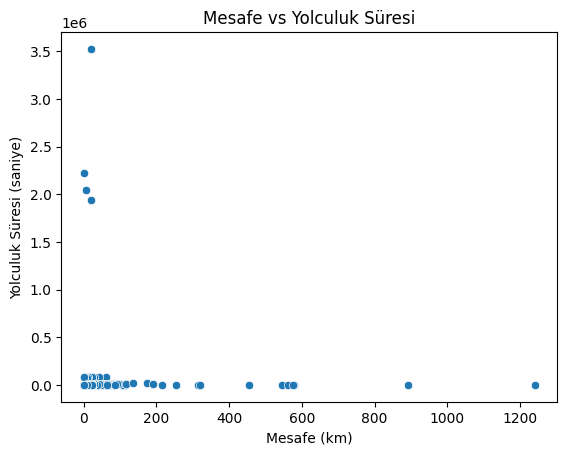

In [6]:

df['pickup_point'] = list(zip(df['pickup_latitude'], df['pickup_longitude']))
df['dropoff_point'] = list(zip(df['dropoff_latitude'], df['dropoff_longitude']))
df['distance'] = df.apply(lambda row: great_circle(row['pickup_point'], row['dropoff_point']).kilometers, axis=1)
# Mesafe-YolculukSüresi Grafik
sns.scatterplot(x='distance', y='trip_duration', data=df)
plt.title('Mesafe vs Yolculuk Süresi')
plt.xlabel('Mesafe (km)')
plt.ylabel('Yolculuk Süresi (saniye)')
plt.show()


Buradaki grafiği ise GPT yardımı olmadan yukarıdaki grafikten sonra aklımda canlandı. Aynı iş yerinde çalışan bazı arkadaşları baz alalım. Bu insanlar yoğun saatlerde eğer işe geç kaldığı bir kaç ana denk geldiyse aynı araca binip gitmiş olabilirler. Onun için Yolcu sayısı ile sürüş süresini karşılaştırmak istedim. Bu veriyi grafikleştirmek isterken yolcu sayısının 0 olduğu veriler gördüm ve bu çok saçma geldi. Çünkü yolcu sayısı 0 ise bir taksi nasıl yolculuk yapabilir ki? Onun için yolcu sayısı 0 olan verileri veri setimden çıkartıyorum ve o şekilde tekrardan grafikleştiriyorum.

In [7]:
# Yolcu sayısı 0 olan sürüşlerin sayısını bulma
sifir_yolcu_sayisi = df[df['passenger_count'] == 0].shape[0]
print(f"Yolcu sayısı 0 olan sürüş sayısı: {sifir_yolcu_sayisi}")


Yolcu sayısı 0 olan sürüş sayısı: 60


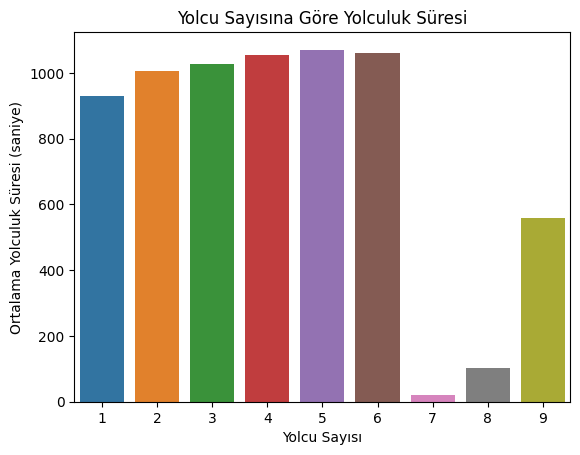

In [8]:
# Yolcu sayısı 0 olan verileri veri setinden çıkarttım. 
df = df[df['passenger_count'] > 0]
# Yolcu sayısı-Yolculuk Süresi Grafik
sns.barplot(x='passenger_count', y='trip_duration', data=df,errorbar=None)
plt.title('Yolcu Sayısına Göre Yolculuk Süresi')
plt.xlabel('Yolcu Sayısı')
plt.ylabel('Ortalama Yolculuk Süresi (saniye)')
plt.show()

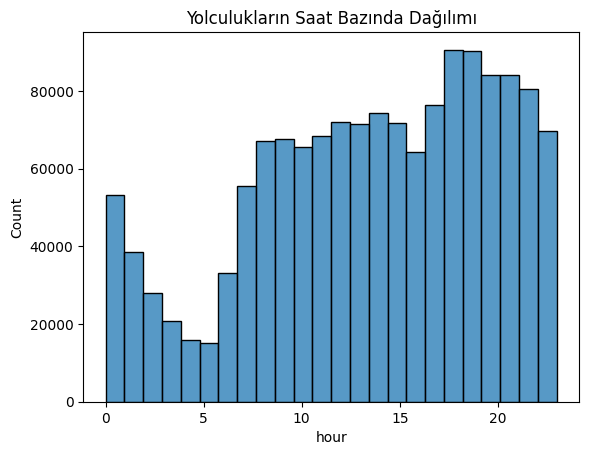

In [9]:
# pickup_datetime'yi zaman formatına çevirme
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# Saat bazında gruplama
df['hour'] = df['pickup_datetime'].dt.hour
sns.histplot(df['hour'], bins=24)
plt.title("Yolculukların Saat Bazında Dağılımı")
plt.show()


# Görselleştirmelerimi yaptıktan sonra Zaman temelli olan özelliklerimi oluşturacağım. Yolculuğun hangi saatte başladığı ya da hafta sonu olup olmadığı gibi örneklerim ile devam edeceğim.

pickup_hour: Yolculuğun başladığı saat

pickup_day_of_week: Haftanın günü (0 = Pazartesi, 6 = Pazar)

is_weekend: Hafta sonu (Cumartesi-Pazar) olup olmadığını belirt (1 = Hafta sonu, 0 = Hafta içi)



In [11]:
# 'pickup_datetime' ve 'dropoff_datetime' sınıflarını datetime çevir
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

# Yolculuğun başladığı saat özelliğini çıkar
df['pickup_hour'] = df['pickup_datetime'].dt.hour

# Haftanın günü özelliğini çıkar
df['pickup_day_of_week'] = df['pickup_datetime'].dt.weekday

# Haftasonu olup olmadığını kontrol et
df['is_weekend'] = df['pickup_day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Çıkartılan özelliklere göz at
print(df[['pickup_hour', 'pickup_day_of_week', 'is_weekend']].head(10))


   pickup_hour  pickup_day_of_week  is_weekend
0           17                   0           0
1            0                   6           1
2           11                   1           0
3           19                   2           0
4           13                   5           1
5           22                   5           1
6           22                   4           0
7            7                   5           1
8           23                   4           0
9           21                   3           0


# Yukarıda günleri belirledikten sonra şimdide yoğun saatleri belirleyeceğim. Sabah ve akşam trafik saatlerini bir zaman aralığı olarak ifade edeceğim.

In [14]:
# Yoğun saat (rush hour) bayrağı ekleyelim: Sabah 7-9 ve Akşam 16-19
def rush_hour_flag(hour):
    if 7 <= hour <= 9 or 16 <= hour <= 19:
        return 1
    else:
        return 0

df['is_rush_hour'] = df['pickup_hour'].apply(rush_hour_flag)

# Yoğun saat bayrağını kontrol edelim
print(df[['pickup_hour', 'is_rush_hour']].head(10))


   pickup_hour  is_rush_hour
0           17             1
1            0             0
2           11             0
3           19             1
4           13             0
5           22             0
6           22             0
7            7             1
8           23             0
9           21             0


In [18]:
def haversine_distance(pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude):
    # Dünya'nın yarıçapı (km cinsinden)
    R = 6371.0
    
    # Enlem ve boylamları radyan cinsine çevirelim
    pickup_lat = math.radians(pickup_latitude)
    pickup_lon = math.radians(pickup_longitude)
    dropoff_lat = math.radians(dropoff_latitude)
    dropoff_lon = math.radians(dropoff_longitude)
    
    # Enlem ve boylam farklarını hesaplayalım
    dlat = dropoff_lat - pickup_lat
    dlon = dropoff_lon - pickup_lon
    
    # Haversine formülünü kullanalım
    a = math.sin(dlat / 2)**2 + math.cos(pickup_lat) * math.cos(dropoff_lat) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    # Mesafeyi hesaplayalım
    distance = R * c
    return distance
df = pd.DataFrame(df)

# Mesafe hesaplamasını yeni bir sütuna ekleyelim
df['trip_distance'] = df.apply(lambda row: haversine_distance(
    row['pickup_longitude'], row['pickup_latitude'], 
    row['dropoff_longitude'], row['dropoff_latitude']), axis=1)

# Sonucu görelim
print(df)


                id  vendor_id     pickup_datetime    dropoff_datetime  \
0        id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   
1        id2377394          1 2016-06-12 00:43:35 2016-06-12 00:54:38   
2        id3858529          2 2016-01-19 11:35:24 2016-01-19 12:10:48   
3        id3504673          2 2016-04-06 19:32:31 2016-04-06 19:39:40   
4        id2181028          2 2016-03-26 13:30:55 2016-03-26 13:38:10   
...            ...        ...                 ...                 ...   
1458639  id2376096          2 2016-04-08 13:31:04 2016-04-08 13:44:02   
1458640  id1049543          1 2016-01-10 07:35:15 2016-01-10 07:46:10   
1458641  id2304944          2 2016-04-22 06:57:41 2016-04-22 07:10:25   
1458642  id2714485          1 2016-01-05 15:56:26 2016-01-05 16:02:39   
1458643  id1209952          1 2016-04-05 14:44:25 2016-04-05 14:47:43   

         passenger_count  pickup_longitude  pickup_latitude  \
0                      1        -73.982155        40.767937 

In [21]:
# Mevcutsa, trip_distance sütununu kontrol edelim
if 'trip_distance' in df.columns:
    print(df['trip_distance'].describe())
else:
    print("Veri setinde 'trip_distance' sütunu yok.")


count    1.458584e+06
mean     3.440954e+00
std      4.296545e+00
min      0.000000e+00
25%      1.231909e+00
50%      2.093782e+00
75%      3.875445e+00
max      1.240909e+03
Name: trip_distance, dtype: float64


Aşağıda copy() methodunu kullandım çünkü önceki yaptığım ekleme kod bloğumda hata çıktı fakat copy() methodunu kullanınca sorun çözüldü.

In [23]:
# Hedef değişken (yolculuk süresi)
target = df['trip_duration']

# Eğer features bir dilimse, tam kopya alarak çalışalım
if 'trip_distance' in df.columns:
    df = df.copy()  # Kopyasını alalım
    df['trip_distance'] = df['trip_distance']

# Ardından, features değişkenini yeniden oluştur:
features = df[['pickup_hour', 'is_rush_hour', 'is_weekend', 'trip_distance']]

# Veriyi eğitim ve test olarak ayıralım
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Veriyi kontrol edelim
print(X_train.head())


         pickup_hour  is_rush_hour  is_weekend  trip_distance
53635              8             1           0       1.163888
756151            20             0           0       3.069778
1076903            4             0           0       3.772008
670212            22             0           0       5.998510
373960             9             1           1       2.149399


# Lineer Regresyon Eğitimi

In [24]:
# Modeli oluştur ve eğit
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Test verisiyle tahmin yapalım
y_pred_lr = linear_model.predict(X_test)

# Model performansını değerlendirelim
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = mse_lr ** 0.5

# Sonuçları yazdıralım
print(f"Lineer Regresyon Mean Absolute Error (MAE): {mae_lr}")
print(f"Lineer Regresyon Root Mean Squared Error (RMSE): {rmse_lr}")


Lineer Regresyon Mean Absolute Error (MAE): 446.5895980822869
Lineer Regresyon Root Mean Squared Error (RMSE): 3104.5413899335613


# Random Forest Eğitimi 

In [25]:
# Modeli oluştur ve eğit
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)

# Test verisiyle tahmin 
y_pred_rf = random_forest_model.predict(X_test)

# Model performansları
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mse_rf ** 0.5

# Sonuçlar
print(f"Random Forest Mean Absolute Error (MAE): {mae_rf}")
print(f"Random Forest Root Mean Squared Error (RMSE): {rmse_rf}")


Random Forest Mean Absolute Error (MAE): 504.8458990599309
Random Forest Root Mean Squared Error (RMSE): 3666.2336641152992


# Model karşılaştırılmaları ve Görselleştirilmesi

In [26]:
print(f"Lineer Regresyon MAE: {mae_lr}, RMSE: {rmse_lr}")
print(f"Random Forest MAE: {mae_rf}, RMSE: {rmse_rf}")

Lineer Regresyon MAE: 446.5895980822869, RMSE: 3104.5413899335613
Random Forest MAE: 504.8458990599309, RMSE: 3666.2336641152992


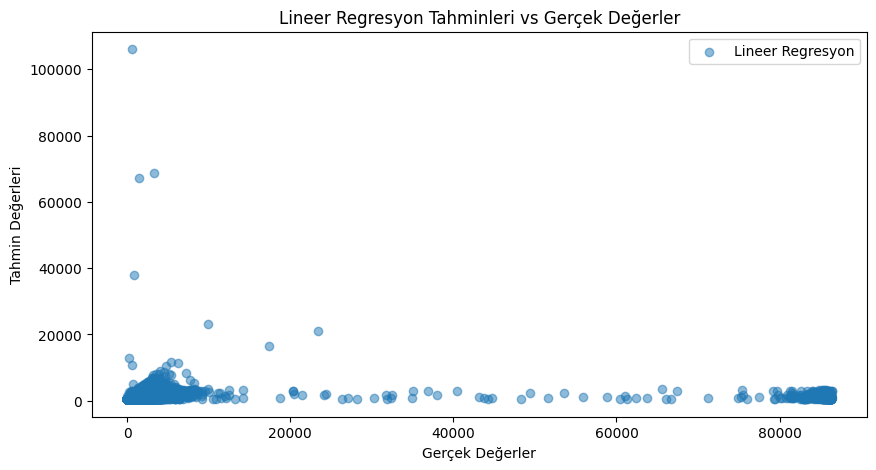

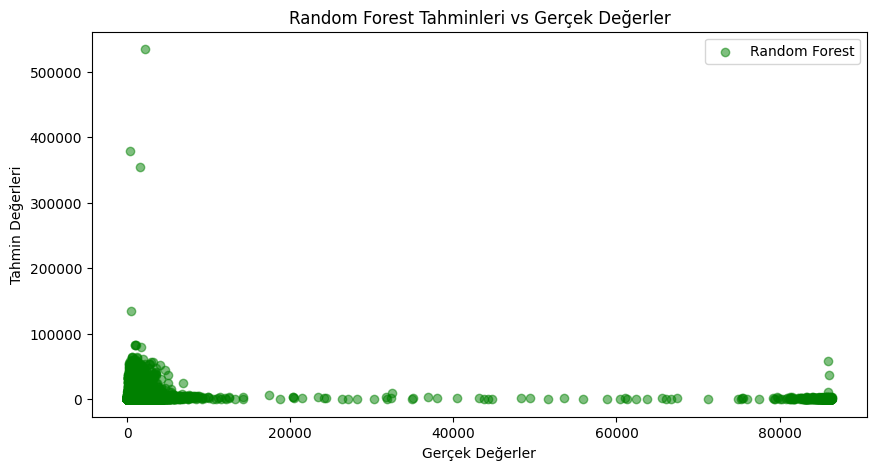

In [27]:
# Lineer Regresyon Tahminleri vs Gerçek Değerler
plt.figure(figsize=(10,5))
plt.scatter(y_test, y_pred_lr, label="Lineer Regresyon", alpha=0.5)
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin Değerleri')
plt.title('Lineer Regresyon Tahminleri vs Gerçek Değerler')
plt.legend()
plt.show()

# Random Forest Tahminleri vs Gerçek Değerler
plt.figure(figsize=(10,5))
plt.scatter(y_test, y_pred_rf, label="Random Forest", alpha=0.5, color='g')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin Değerleri')
plt.title('Random Forest Tahminleri vs Gerçek Değerler')
plt.legend()
plt.show()

# Cross Validation

Normalde öncelikle bir Cross Validation yaptım fakat aşırı uzun sürdüğü için veri setinin %10 ile iş yapmak istedim ve 3 katlı bir işlem yaptım. Ve n_estimators değişkenini 100'den 50'ye indirdim. Normalde önceki yaptığım işlem 5 katlı idi ve veri setinin hepsi ile yaptım. Fakat bu işşlem yaklaşık olarak 30 dkyi geçti ve halen yapmaya devam ediyordu. Onun için bu çapraz sorgulama ve model değerlendirmesini Ver isetinin ufak bir kısmı ile yapmak zorunda kaldım. 

In [38]:
# Veri setinden %10'luk bir örneklem alıyoruz
data_sample = df.sample(frac=0.1, random_state=42)

# Hedef değişken (yolculuk süresi) ve özellikler
target_sample = data_sample['trip_duration']

features_sample = data_sample[['pickup_hour', 'is_rush_hour', 'is_weekend']]
if 'trip_distance' in df.columns:
    features_sample = features_sample.copy()
    features_sample['trip_distance'] = data_sample['trip_distance']


In [39]:
# Lineer Regresyon modeli
linear_model = LinearRegression()

# Random Forest modeli
random_forest_model = RandomForestRegressor(n_estimators=50, random_state=42)

In [40]:
# MAE ve RMSE skorerlerini tanımlama
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(rmse, greater_is_better=False)


In [42]:
# 3 Kat Cross
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Lineer Regresyon Cross
linear_cv_results = cross_validate(
    linear_model, 
    features_sample, 
    target_sample, 
    cv=kf, 
    scoring={'MAE': mae_scorer, 'RMSE': rmse_scorer},
    return_train_score=False
)

# Random Forest Cross
rf_cv_results = cross_validate(
    random_forest_model, 
    features_sample, 
    target_sample, 
    cv=kf, 
    scoring={'MAE': mae_scorer, 'RMSE': rmse_scorer},
    return_train_score=False
)


# Sonuçların incelenmesi - Modellerin değerlendirilmesi
   Lineer Regresyon modelim için Mean Absolute Error(MAE) kullandım. Bu değer, modelimin tahminlerinin gerçek değerlerden ne kdaar sapma gösterdiğinin ortalmasıdır. Yolculuk süresinin kaç saniye sapabileceğini ortalama olarak göstermeye yarar. Lineer Regresyon için **452.76 saniye**, Random Forest için **320.96** saniye olarak değer aldım.
   
   Buradaki değerlere göre Random Forest modelinin tahminlerinin Lineer Regresyon modelinden daha doğru olduğunu söyleyebilirim çünkü MAE daha düşük gösteriyor.
   
   Random Forest modelim için Root Mean Squared Error(RMSE) kullandım. Bu değer modelin hatalarının karelerinin ortalamasının kareköküdür. RMSE, büyük hatalara daha duyarlı ve daha yüksek bir sapma gösteren tahminlerde ona göre daha fazla ceza verir. Lineer Regrezyon için **3190.53** saniye, Random Forest için **3528.12** saniye olarak değer aldım. 
   
   RMSE, değerinde sise Random Forest Modelinin hata karelerinin ortalaması Lineer Regresyona göre daha yüksek çıkmış, bu da büyük sapmaların daha fazla olduğunu gösteriyor.
   
   Projemde, yoğun saatler ve iş saatlerine bağlı olarak yolculuk süresini tahmin etmeye çalıştım. Random Forest daha iyi sonuç verebileceğini düşündüğüm çünkü saat dilimleri ve trafik yoğunluğu gibi karmaşık ilişkileri daha iyi yakalayabileceğini düşündüğüm için onu ve Lineer Regresyon modelini karşılaştırmak istedim. 

In [43]:
# Lineer Regresyon sonuçları
print("Lineer Regresyon Çapraz Doğrulama Sonuçları:")
print(f"MAE: {-np.mean(linear_cv_results['test_MAE']):.2f} ± {np.std(linear_cv_results['test_MAE']):.2f}")
print(f"RMSE: {-np.mean(linear_cv_results['test_RMSE']):.2f} ± {np.std(linear_cv_results['test_RMSE']):.2f}")

# Random Forest sonuçları
print("\nRandom Forest Çapraz Doğrulama Sonuçları:")
print(f"MAE: {-np.mean(rf_cv_results['test_MAE']):.2f} ± {np.std(rf_cv_results['test_MAE']):.2f}")
print(f"RMSE: {-np.mean(rf_cv_results['test_RMSE']):.2f} ± {np.std(rf_cv_results['test_RMSE']):.2f}")


Lineer Regresyon Çapraz Doğrulama Sonuçları:
MAE: 452.76 ± 9.18
RMSE: 3190.53 ± 63.45

Random Forest Çapraz Doğrulama Sonuçları:
MAE: 502.96 ± 1.22
RMSE: 3520.12 ± 53.92
